In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [18]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

# TITLE

Little text to explain main idea

## 1) Loading data and basic analysis

Could contain, how many rows, columns, missing values, etc.

### Data cleaning

Drop fill missing values, etc.

In [19]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## User dataframe (The user dataframe are similar for both platforms)

In [20]:
users_df_ba.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland




1. **nbr_ratings**: Number of beer ratings by users.
2. **nbr_reviews**: Count of beer reviews submitted.
3. **user_id**: Unique identifier for users.
4. **user_name**: Usernames associated with users.
5. **joined**: Date when users joined the platform.
6. **location**: Geographical location of users.

## Breweries dataframe

In [21]:
breweries_df.head()

,brewery_id_ba,brewery_location_ba,brewery_name_ba,brewery_nbr_beers_ba,brewery_id_rb,brewery_nbr_beers_rb
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,5
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,2
2,40360,Northern Ireland,Walled City Brewing Company,6,24866,3
3,40309,Northern Ireland,Ards Brewing Company,7,13538,13
4,41205,Northern Ireland,Barrahooley Brewery,3,22304,4


1. **brewery_id_ba**: Unique identifier for breweries on BeerAdvocate.
2. **brewery_location_ba**: Geographical location of breweries on BeerAdvocate.
3. **brewery_name_ba**: Names of breweries on BeerAdvocate.
4. **brewery_nbr_beers_ba**: Number of beers associated with each brewery on BeerAdvocate.
5. **brewery_id_rb**: Unique identifier for breweries on RateBeer.
6. **brewery_nbr_beers_rb**: Number of beers associated with each brewery on RateBeer.

## Beers dataframe (enriched with data from breweries dataframe)

- The rows contain the different beers rated on the two platforms

In [22]:
beers_df.head()

,abv_ba,beer_avg_rating_ba,beer_id_ba,beer_name_ba,brewery_id_ba,nbr_ratings_ba,style_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location_ba,brewery_name_ba,brewery_nbr_beers_ba,brewery_nbr_beers_rb
0,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
1,6.0,3.888750,20841,St. Patrick's Ale,10093,8,English Pale Ale,3.290909,41286,4959,11,3.542632,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
2,4.2,3.556094,20842,St. Patrick's Best,10093,64,English Bitter,2.831081,41287,4959,74,3.167319,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
3,4.8,3.960000,22659,St. Patrick's Gold,10093,1,American Pale Wheat Ale,2.775000,41285,4959,4,3.012000,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
4,4.5,NaN,178681,Sheelin Stout,32848,0,Irish Dry Stout,3.200000,230283,17616,2,NaN,Northern Ireland,The Sheelin Brewery,4,2


1. **abv_ba**: Alcohol by volume for beers on BeerAdvocate.
2. **beer_avg_rating_ba**: Average rating for beers on BeerAdvocate.
3. **beer_id_ba**: Unique identifier for beers on BeerAdvocate.
4. **beer_name_ba**: Names of beers on BeerAdvocate.
5. **brewery_id_ba**: Unique identifier for breweries associated with BeerAdvocate.
6. **nbr_ratings_ba**: Number of ratings for beers on BeerAdvocate.
7. **style_ba**: Beer style on BeerAdvocate.
8. **beer_avg_rating_rb**: Average rating for beers on RateBeer.
9. **beer_id_rb**: Unique identifier for beers on RateBeer.
10. **brewery_id_rb**: Unique identifier for breweries associated with RateBeer.
11. **nbr_ratings_rb**: Number of ratings for beers on RateBeer.
12. **beer_avg_rating_ba_rb**: Average rating for beers on both BeerAdvocate and RateBeer.
13. **brewery_location_ba**: Geographical location of breweries on BeerAdvocate.
14. **brewery_name_ba**: Names of breweries on BeerAdvocate.
15. **brewery_nbr_beers_ba**: Number of beers associated with each brewery on BeerAdvocate.
16. **brewery_nbr_beers_rb**: Number of beers associated with each brewery on RateBeer.

## Complete reviews dataframe

In [23]:
reviews_df.head()

,beer_name,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_id_ba,brewery_id_ba,nbr_ratings_ba,style,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings
0,Legbiter,19827,English Pale Ale,1417431600,Hellpop65,hellpop65.48993,nan,nan,nan,nan,nan,3.25,nan,False,4.8,3.439867,19827,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",2326.0
1,Legbiter,19827,English Pale Ale,1401357600,Latarnik,latarnik.52897,nan,nan,nan,nan,nan,3.50,nan,False,4.8,3.439867,19827,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, New Jersey",3098.0
2,Legbiter,19827,English Pale Ale,1393412400,RochefortChris,rochefortchris.697017,nan,nan,nan,nan,nan,3.50,nan,False,4.8,3.439867,19827,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, North Carolina",1866.0
3,Legbiter,19827,English Pale Ale,1392030000,OKCNittany,okcnittany.144868,nan,nan,nan,nan,nan,3.75,nan,False,4.8,3.439867,19827,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Oklahoma",1131.0
4,Legbiter,19827,English Pale Ale,1390647600,jaydoc,jaydoc.265507,nan,nan,nan,nan,nan,3.25,nan,False,4.8,3.439867,19827,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",9987.0


1. **beer_name**: Name of the rated beer.
2. **beer_id**: Unique identifier for the rated beer.
3. **style**: Style of the rated beer.
4. **date**: Date of the rated review.
5. **user_name**: Name of the user providing the rated review.
6. **user_id**: Unique identifier for the user.
7. **appearance**: Rating for the appearance of the rated beer.
8. **aroma**: Rating for the aroma of the rated beer.
9. **palate**: Rating for the palate of the rated beer.
10. **taste**: Rating for the taste of the rated beer.
11. **overall**: Overall rating for the rated beer.
12. **rating**: Another rating associated with the rated beer.
13. **text**: Textual content of the rated review.
14. **review**: Another aspect of the rated review.
15. **abv**: Alcohol by volume for the rated beer.
16. **beer_avg_rating_ba**: Average rating for the rated beer on BeerAdvocate.
17. **beer_id_ba**: Unique identifier for the rated beer on BeerAdvocate.
18. **brewery_id_ba**: Unique identifier for the brewery associated with the rated beer on BeerAdvocate.
19. **nbr_ratings_ba**: Number of ratings for the rated beer on BeerAdvocate.
20. **beer_avg_rating_rb**: Average rating for the rated beer on RateBeer.
21. **beer_id_rb**: Unique identifier for the rated beer on RateBeer.
22. **brewery_id_rb**: Unique identifier for the brewery associated with the rated beer on RateBeer.
23. **nbr_ratings_rb**: Number of ratings for the rated beer on RateBeer.
24. **beer_avg_rating_ba_rb**: Average rating for the rated beer on both BeerAdvocate and RateBeer.
25. **brewery_location**: Geographical location of the brewery associated with the rated beer.
26. **brewery_name**: Name of the brewery associated with the rated beer.
27. **brewery_nbr_beers_ba**: Number of beers associated with the brewery of the rated beer on BeerAdvocate.
28. **brewery_nbr_beers_rb**: Number of beers associated with the brewery of the rated beer on RateBeer.
29. **user_location**: Geographical location of the user.
30. **user_nbr_ratings**: Number of ratings provided by the user.

## Is focusing on the US a feasible idea ?

### Numerical reviews

Here we want only the revieys of users in the US and then drop the beers with less than 10 reviews and see how many reviews per state there is after it.

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_14636\3647483497.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]


 Percentage of ratings left:  95.7657271977251 %


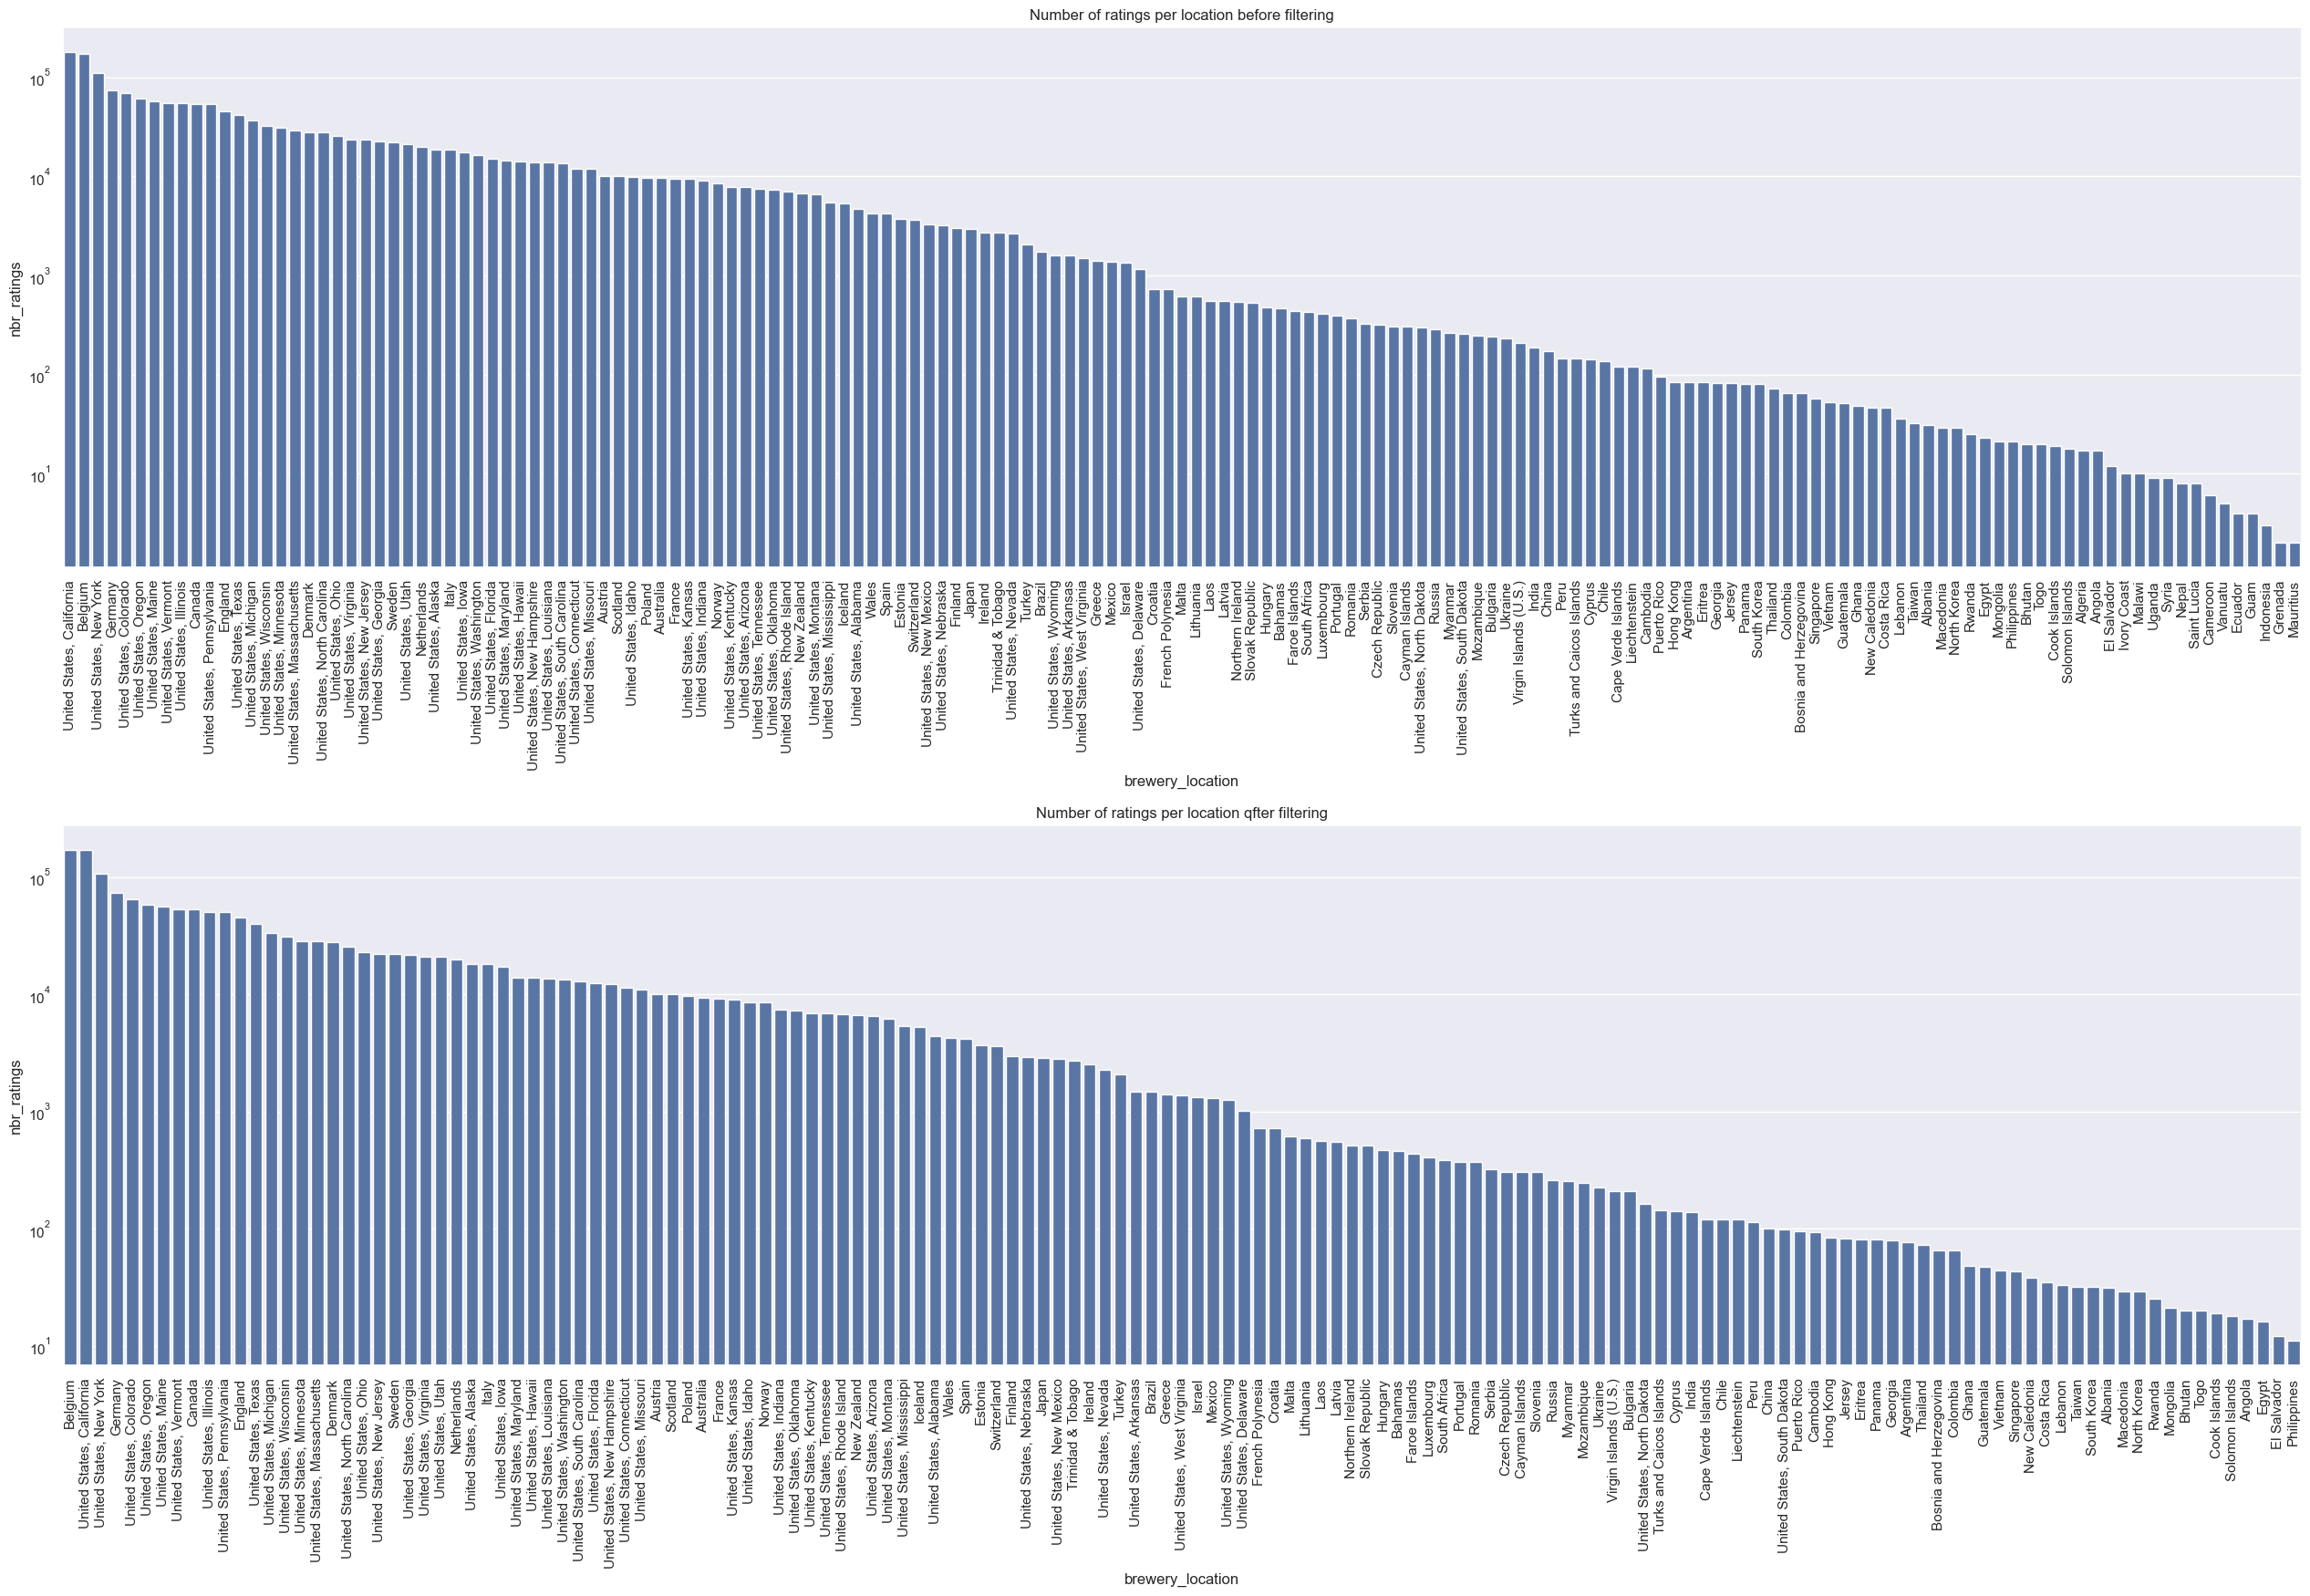

In [70]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]
#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

unique_beers = us_users_ratings[["beer_id", "nbr_ratings", "brewery_location"]].copy().drop_duplicates()
total_ratings = unique_beers["nbr_ratings"].sum()

unique_beers = unique_beers.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=unique_beers, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of ratings per location before filtering")
axs[0].set(yscale="log")


#only keep beers with more than 10 ratings
us_users_ratings = us_users_ratings[us_users_ratings["nbr_ratings"] > 10]

beers_left = us_users_ratings[["beer_id","nbr_ratings", "brewery_location"]].copy().drop_duplicates()

beers_left = beers_left.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

ratings_left = beers_left["nbr_ratings"].sum()
print(" Percentage of ratings left: ", ratings_left / total_ratings * 100, "%")

beers_left["Percentage of ratings"] = beers_left["nbr_ratings"] / beers_left["nbr_ratings"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=beers_left, orient="v", ax=axs[1])
axs[1].set_title("Number of ratings per location qfter filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")


In [61]:
beers_left.head(10)

,brewery_location,nbr_ratings,Percentage of ratings
0,Belgium,170624,10.102611
1,"United States, California",170101,10.071644
2,"United States, New York",107077,6.340006
3,Germany,73291,4.339544
4,"United States, Colorado",64915,3.843603
5,"United States, Oregon",58300,3.451931
6,"United States, Maine",56170,3.325814
7,"United States, Vermont",53184,3.149013
8,Canada,53145,3.146704
9,"United States, Illinois",50488,2.989384


Looking at the two bar plots above, we can see that removing beers with less than 10 reviews does not change the distribution of the dataset. ****** **maybe do a statistical test for this but which one ?** ******

### Textual reviews

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_14636\1583596311.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]


 Percentage of ratings left:  81.32945308249106 %


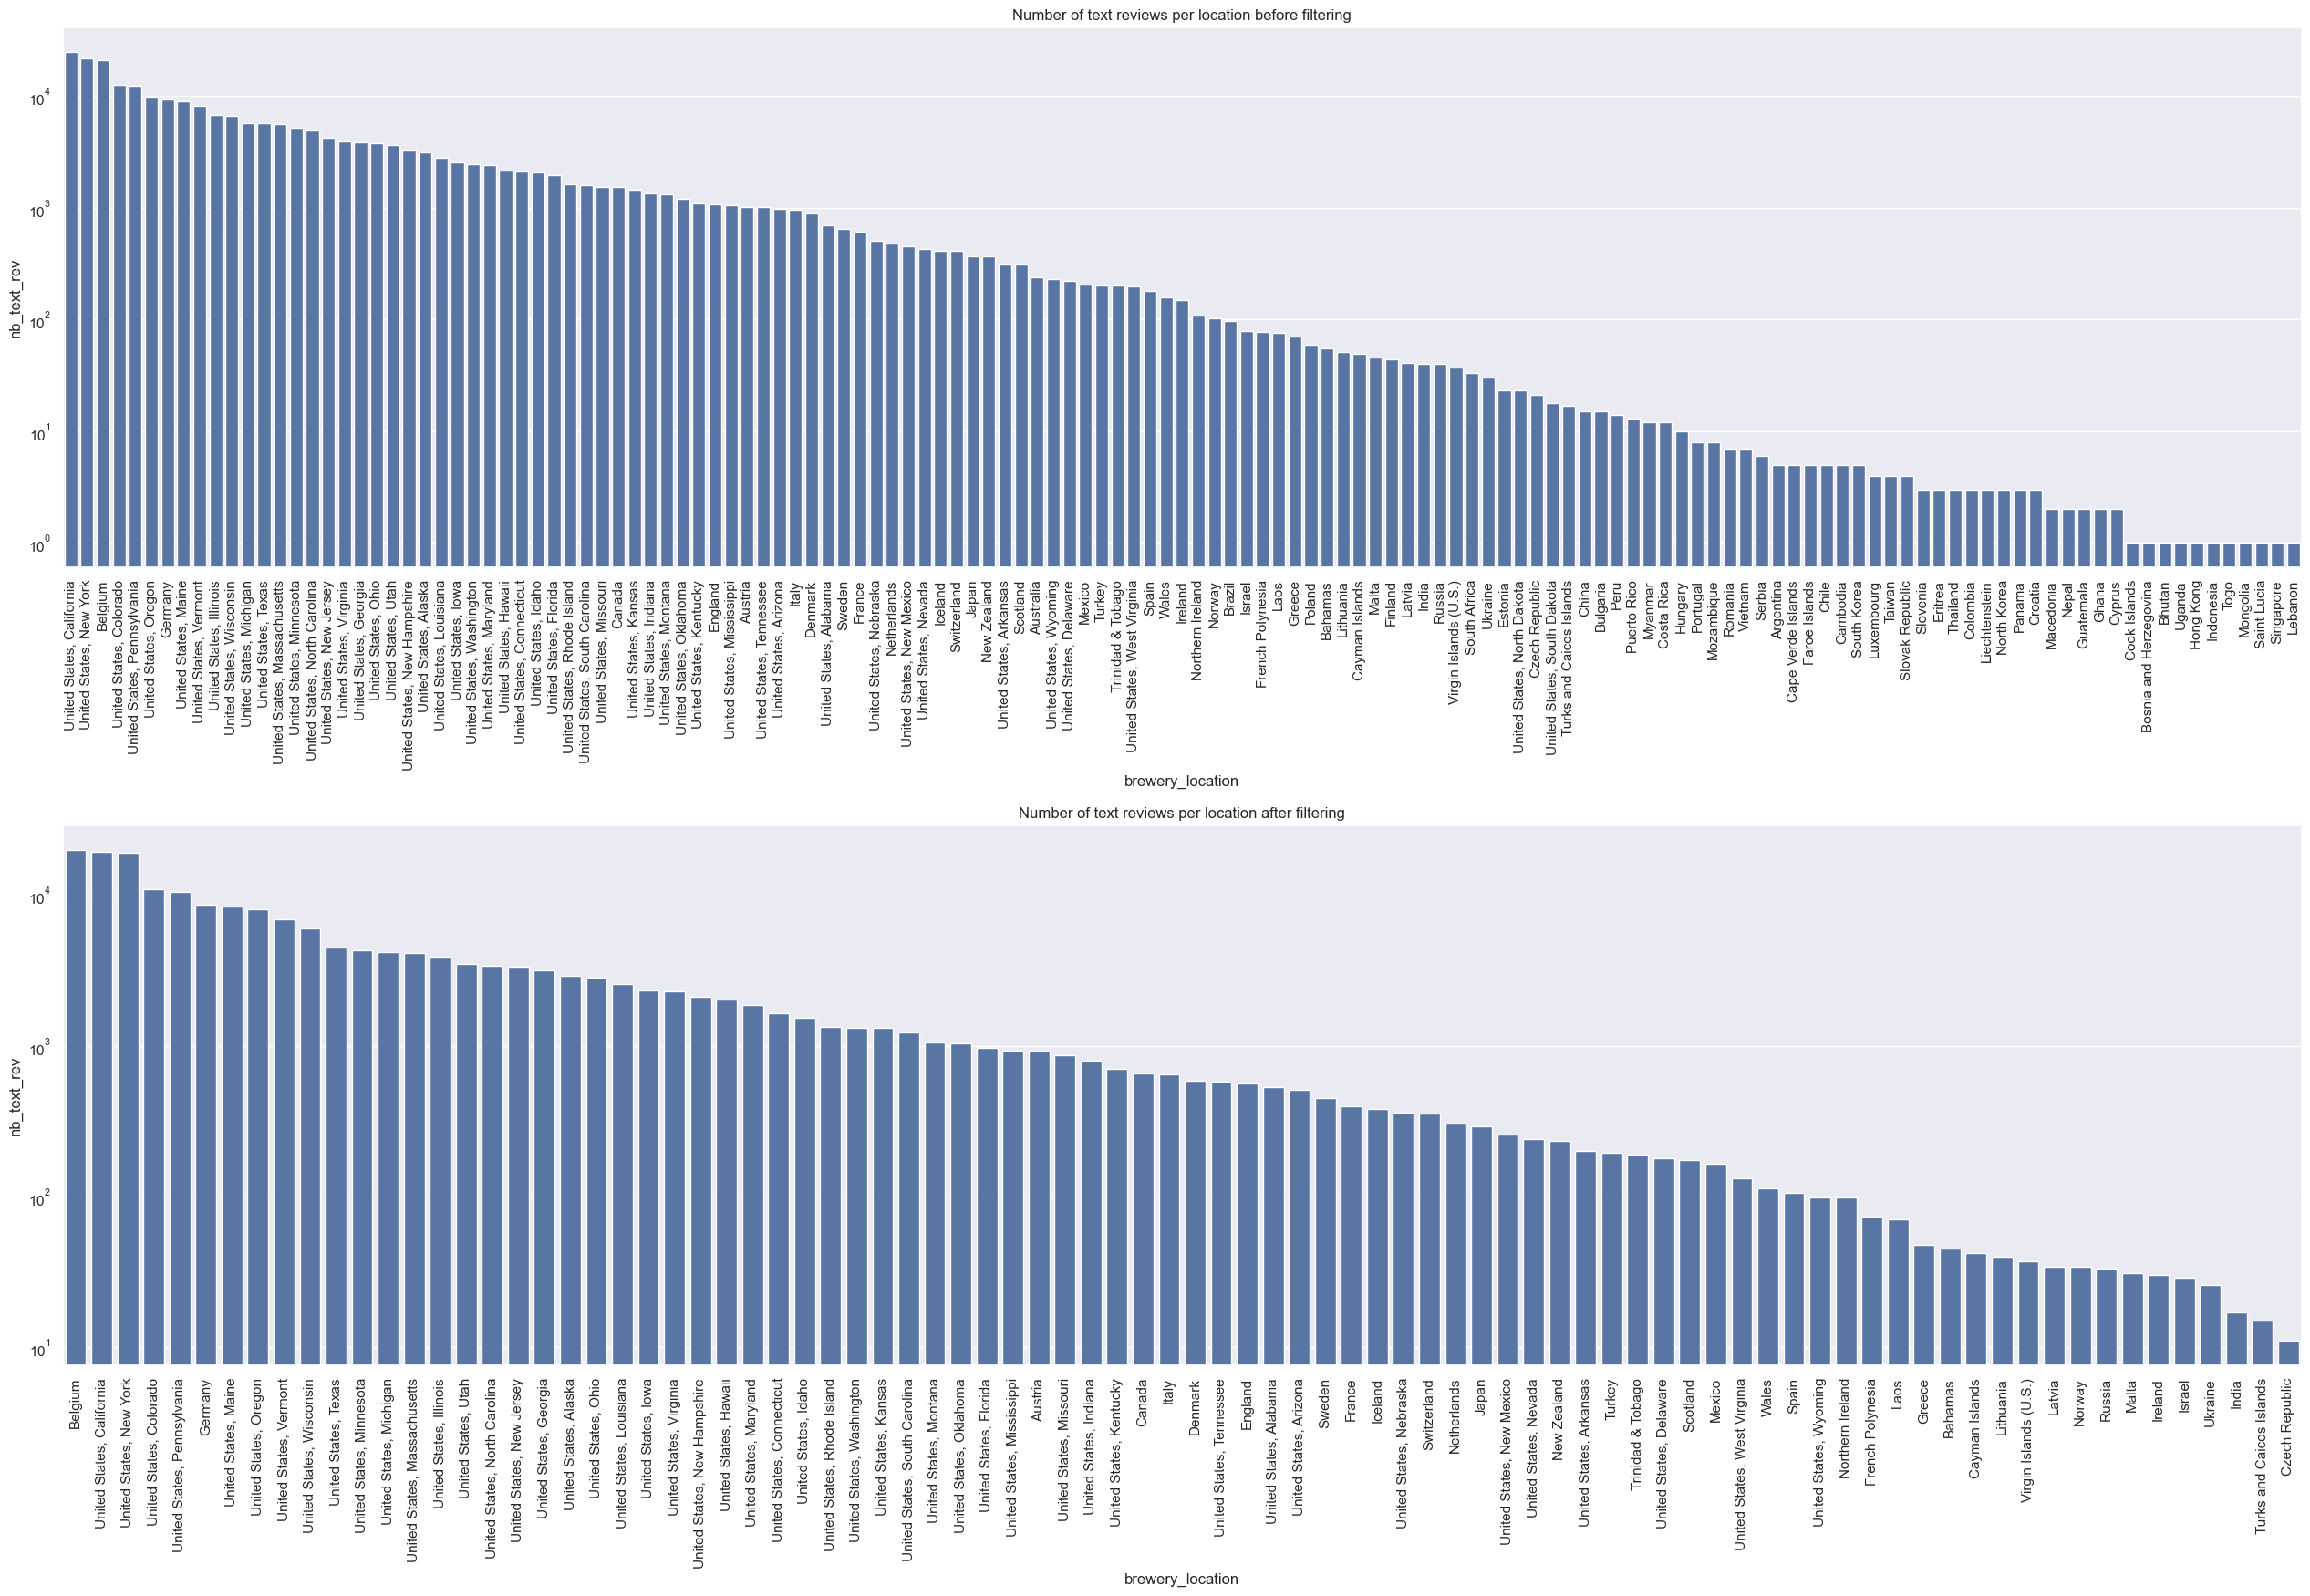

In [82]:
world_ratings = reviews_df.copy()
#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_txt = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]

#only reviews with text review
us_users_txt = us_users_txt[us_users_txt["text"]!="nan"]

#count number of text reviews per beer

us_users_txt["nb_text_rev"] = us_users_txt.groupby("beer_id")["text"].transform("count")


unique_beers_txt = us_users_txt[["beer_id", "nb_text_rev", "brewery_location"]].copy().drop_duplicates()
total_ratings_txt = unique_beers_txt["nb_text_rev"].sum()

unique_beers_txt = unique_beers_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=unique_beers_txt, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of text reviews per location before filtering")
axs[0].set(yscale="log")


#only keep beers with more than 10 ratings
us_users_txt = us_users_txt[us_users_txt["nb_text_rev"] > 10]

beers_left_txt = us_users_txt[["beer_id","nb_text_rev", "brewery_location"]].copy().drop_duplicates()

beers_left_txt = beers_left_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

ratings_left_txt = beers_left_txt["nb_text_rev"].sum()
print(" Percentage of ratings left: ", ratings_left_txt / total_ratings_txt * 100, "%")

beers_left_txt["Percentage of ratings"] = beers_left_txt["nb_text_rev"] / beers_left_txt["nb_text_rev"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=beers_left_txt, orient="v", ax=axs[1])
axs[1].set_title("Number of text reviews per location after filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")


In [83]:
beers_left_txt.head(10)

,brewery_location,nb_text_rev,Percentage of ratings
0,Belgium,20037,10.155498
1,"United States, California",19526,9.896504
2,"United States, New York",19223,9.742932
3,"United States, Colorado",11051,5.601058
4,"United States, Pennsylvania",10538,5.341051
5,Germany,8679,4.398840
6,"United States, Maine",8442,4.278720
7,"United States, Oregon",8027,4.068382
8,"United States, Vermont",6881,3.487547
9,"United States, Wisconsin",6029,3.055722


For the text reviews, we can see that we have less location but the distribution does't change that much.

## 2) First analysis : how beers from one country are rated (reviewed)

We first want to look at how beers from a given country are perceived by users. We start from the full dataframe with all the reviews.

### Data cleaning

Let's first look at distribution of number of reviews

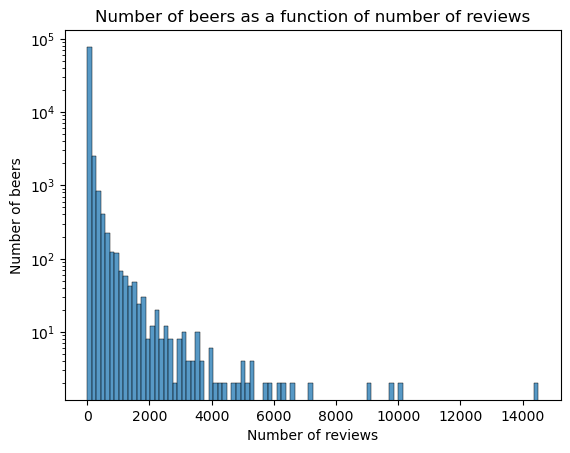

In [177]:
# Copy the dataset to avoid modifying the original
country_ratings = reviews_df.copy()

# Plot number of beers as a function of number of reviews
# -------------------------
# POTENTIELLEMENT DEJA FAIT DANS LES LOADING SI ALBAN A CHANGE LE CODE
# AUQUEL CAS MODIFIER LES 2 LIGNES SUIVANTES
# -------------------------
country_ratings["nbr_ratings"] = country_ratings["nbr_ratings_rb"] + country_ratings["nbr_ratings_ba"]
unique_beers = country_ratings[["beer_id", "nbr_ratings"]].copy().drop_duplicates()

sns.histplot(data=unique_beers, x="nbr_ratings", bins=100)
plt.yscale("log")
plt.xlabel("Number of reviews")
plt.ylabel("Number of beers")
plt.title("Number of beers as a function of number of reviews")
plt.show()

We notice that a great number of beers have very few reviews, which might lead to biased results. We therefore decide to only keep beers with more than 10 reviews.

In [178]:
# Keep initial length for comparison
initial_len = len(reviews_df)
print("Number of unique beers initially: ", len(reviews_df["beer_id"].unique()))

# Keep the reviews only for beers with at least 10 reviews
country_ratings = country_ratings[country_ratings["nbr_ratings"] >= 10]

intermediate_len = len(country_ratings)

print("Number of unique beers after filtering: ", len(country_ratings["beer_id"].unique()))
print("Percentage of reviews kept: {:.2f} %".format(intermediate_len / initial_len * 100))

Number of unique beers initially:  79628
Number of unique beers after filtering:  42665
Percentage of reviews kept: 95.25 %


Notice how we lose less than 5% reviews despite removing ~50% of the beers. That way the analysis we will do on each beer will be more robust.

Similarly, we remove every countries with less than 10 beers.

In [179]:
# We will now compute for each location the number of beer reviewed
num_unique_beers = country_ratings.groupby("brewery_location")["beer_id"].nunique()
num_unique_beers = num_unique_beers.to_frame().reset_index()
num_unique_beers.columns = ["brewery_location", "num_unique_beers"]

print("Number of countries initially: ", len(reviews_df["brewery_location"].unique()))

# Keep only the countries with at least 10 unique beers
country_ratings = country_ratings.merge(num_unique_beers, on="brewery_location")
country_ratings = country_ratings[country_ratings["num_unique_beers"] >= 10]

print("Number of countries after filtering: ", len(country_ratings["brewery_location"].unique()))
final_len = len(country_ratings)

print('Initial number of reviews: ', initial_len)
print('Final number of reviews: ', final_len)
print('Percentage of reviews kept: {:.2f}%'.format(final_len / initial_len * 100))

Number of countries initially:  174
Number of countries after filtering:  109
Initial number of reviews:  1976606
Final number of reviews:  1878458
Percentage of reviews kept: 95.03%


At the end, we keep 95% of the original dataset for this analysis which is a good compromise to have significant results.

### Analysis

We want to take a first look at the average ratings of beers from different countries. We use the average rating of each beer for now, it is itself the average across the 5 different scores (Overall, Taste, Palate, Aroma, and Appearance).

We noticed first that the United States are separated by states, so regrouped them. We do the same for the United Kingdom, which is separated by countries.

Then, we can compute the average rating for every beers coming from the same brewery_location (ie country of origin).

In [180]:
# Convert the rating column to float
country_ratings["rating"] = country_ratings["rating"].astype(float)

filtered_country_ratings = country_ratings.copy()
# Replace the country names by the official names
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("United States"), "brewery_location"] = "United States of America"

filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("England"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Scotland"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Wales"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Northern Ireland"), "brewery_location"] = "United Kingdom"

# For each country compute the average rating
avg_ratings = filtered_country_ratings.groupby("brewery_location")["rating"].mean()
avg_ratings = avg_ratings.to_frame().reset_index()
avg_ratings.columns = ["brewery_location", "avg_rating"]

avg_ratings.head()

,brewery_location,avg_rating
0,Argentina,3.252430
1,Australia,3.274803
2,Austria,3.309164
3,Bahamas,2.727022
4,Belgium,3.741002


Using geopandas, we can get a map from the world by country. We can then plot the average rating for each country on this map.

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\2386512447.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


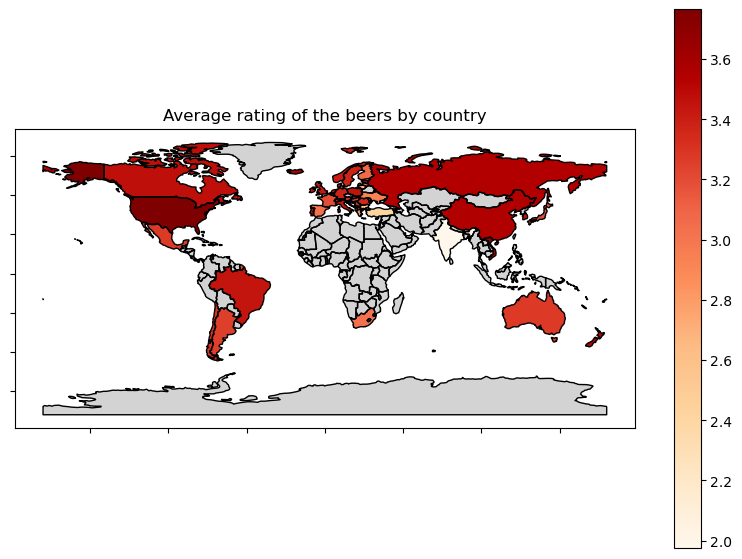

In [181]:
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(avg_ratings, left_on="name", right_on="brewery_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="avg_rating", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Average rating of the beers by country")
plt.show()

We see that only a small parts of the world still has data (all grey countries are the ones already removed from our analysis by preprocessing). We are therefore interested in which countries have the highest amount of beers.

In [182]:
# Print the countries with highest number of beers
num_unique_beers = num_unique_beers.sort_values(by="num_unique_beers", ascending=False)
num_unique_beers.head(20)

,brewery_location,num_unique_beers
102,"United States, California",3779
12,Canada,3237
27,England,2832
110,"United States, Illinois",1735
129,"United States, New York",1716
35,Germany,1548
6,Belgium,1473
89,Sweden,1346
135,"United States, Pennsylvania",1087
134,"United States, Oregon",1067


We notice that in the first 20 locations, only Australia is neither a state of the US nor a country in Europe. For this first look at the data we thus look into these two regions.

To do so, we restart from the data before mergin the US in one, and we found a map of the United States (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). We can then plot the average rating for each state on this map.

In [183]:
# Redoing the same but only for Europe and the US separately
united_states_ratings = country_ratings[country_ratings["brewery_location"].str.contains("United States")]

avg_US_ratings = united_states_ratings.groupby("brewery_location")["rating"].mean()
avg_US_ratings = avg_US_ratings.to_frame().reset_index()
avg_US_ratings.columns = ["brewery_location", "avg_rating"]

names_states = avg_US_ratings["brewery_location"].unique()
# From each name remove "Unites Sates, "
names_states = [name.replace("United States, ", "") for name in names_states]
avg_US_ratings["brewery_location"] = names_states

# Load map from file
us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")

us_map = us_map.merge(avg_US_ratings, left_on="NAME", right_on="brewery_location", how="right")


# For display purposes, move Alaska and Hawaii to the East
alaska = us_map[us_map["NAME"] == "Alaska"].geometry
hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

alaska = alaska.translate(xoff=40)
hawaii = hawaii.translate(xoff=40)

us_map_shifted = us_map.copy()
us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii

We also used our original map of the world to plot the average rating for each country in Europe. By keeping only countries in Europe.

In [184]:
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

europe_map = world[world["continent"] == "Europe"]
europe_map = europe_map.merge(avg_ratings, left_on="name", right_on="brewery_location", how="left");

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\2998335199.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Finally here are the two maps:

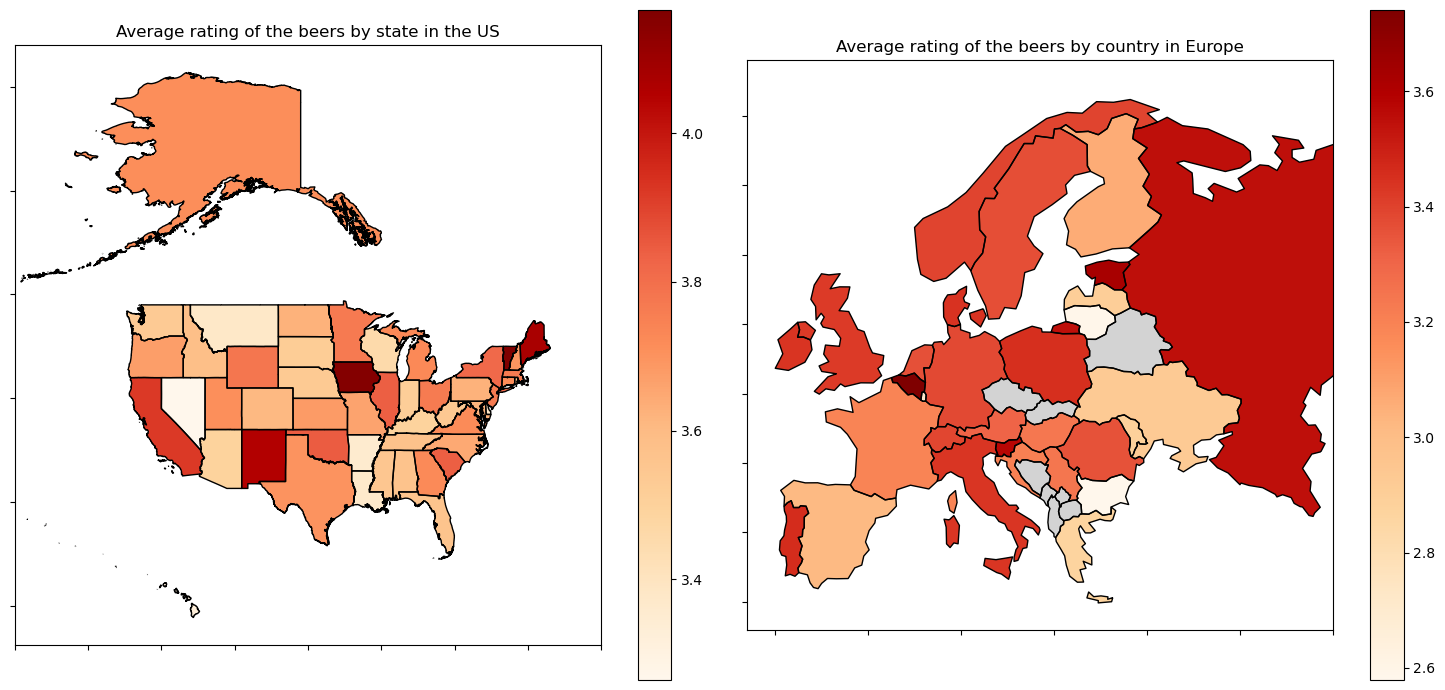

In [185]:
# Plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

us_map_shifted.boundary.plot(ax=ax[0], linewidth=1, color="black")
us_map_shifted.plot(column="avg_rating", ax=ax[0], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim(-140, -60)
ax[0].set_title("Average rating of the beers by state in the US")


europe_map.boundary.plot(ax=ax[1], linewidth=1, color="black")
europe_map.plot(column="avg_rating", ax=ax[1], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlim(-13, 50)
ax[1].set_ylim(33, 74)
ax[1].set_title("Average rating of the beers by country in Europe")

plt.tight_layout()
plt.show()

We can observe that there is a difference in ratings from one place to another, and it seems interesting to look more into details in these statistics. We wish to look more in details for the different subcategories of ratings (Overall, Taste, Palate, Aroma, and Appearance) and try to see which of the differences are significant.

#### Word clouds

Then we will try to represent the beers of one country with a wordcloud made of the most used adjectives from the text reviews. For this we first need to do again some data cleaning. Before we kept the countries with more than 10 beers which have more than 10 reviews, but we did not care about text reviews, only the ratings. Here we need to do the same but looking at the text reviews, for the same reasons as stated above.

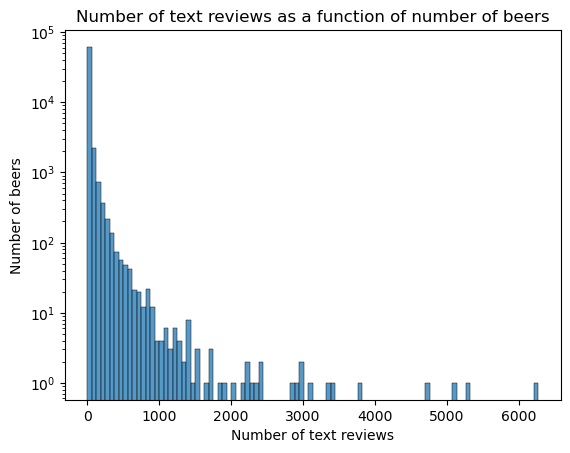

In [186]:
# Copy the dataset to avoid modifying the original
country_text_rev = reviews_df.copy()

#drop all the rows where there is no text review
country_text_rev = country_text_rev[country_text_rev['text']!='nan']

initial_len = len(country_text_rev)

nb_text_rev = country_text_rev.groupby('beer_name').count()

#plot number of text reviews for each beer
sns.histplot(data=nb_text_rev, x="text", bins=100)
plt.yscale("log")
plt.xlabel("Number of text reviews")
plt.ylabel("Number of beers")
plt.title("Number of text reviews as a function of number of beers")
plt.show()

In [187]:
#keep only the beers with at least 10 text reviews
nb_text_rev = nb_text_rev[nb_text_rev['text']>=10]
beers_to_keep = nb_text_rev.index
country_text_rev = country_text_rev[country_text_rev['beer_name'].isin(beers_to_keep)]

intermediate_len = len(country_text_rev)

print('Initial number of reviews: ', initial_len)
print('Intermediate number of reviews: ', intermediate_len)
print('Percentage of reviews kept: {:.2f}%'.format(intermediate_len / initial_len * 100))

Initial number of reviews:  1309663
Intermediate number of reviews:  1173522
Percentage of reviews kept: 89.60%


In [188]:
# We will now compute for each location the number of beer reviewed
num_unique_beers = country_text_rev.groupby("brewery_location")["beer_id"].nunique()
num_unique_beers = num_unique_beers.to_frame().reset_index()
num_unique_beers.columns = ["brewery_location", "num_unique_beers"]

print("Number of countries initially: ", len(country_text_rev["brewery_location"].unique()))

# Keep only the countries with at least 10 unique beers
country_text_rev = country_text_rev.merge(num_unique_beers, on="brewery_location")
country_text_rev = country_text_rev[country_text_rev["num_unique_beers"] >= 10]

print("Number of countries after filtering: ", len(country_text_rev["brewery_location"].unique()))
final_len = len(country_text_rev)

print('Initial number of reviews: ', initial_len)
print('Final number of reviews: ', final_len)
print('Percentage of reviews kept: {:.2f}%'.format(final_len / initial_len * 100))

Number of countries initially:  151
Number of countries after filtering:  95
Initial number of reviews:  1309663
Final number of reviews:  1166793
Percentage of reviews kept: 89.09%


Now that we have cleaned the data to only keep countries with more than 10 different beers that have more than 10 reviews, we will show how we will implement the wordclouds.

To achieve this, we will be using some new python librairies :
<ul>
    <li> <em> spacy </em> : a library for advanced Natural Language Processing with which we will find adjectives in the text reviews </li>
    <li> <em> wordcloud </em> : a library to create wordclouds</li>
</ul>

First, we need to run the following commands in the terminal to install these librairies:

```bash
pip install spacy
python -m spacy download en_core_web_sm
pip install wordcloud
```

In [189]:
import spacy
import textwrap
import wordcloud

#load nlp model from spacy
nlp = spacy.load("en_core_web_sm")

In [190]:
#select first review
text = country_text_rev['text'].iloc[0]

#print first review neatly
wrapped_text = textwrap.fill(text, width=135)
print('First textual review: ', wrapped_text, sep='\n')

First textual review: 
This was a 12 oz bottle poured into a snifter.It pours a dark brown with some clarity but not truly transparent. It has a frothy head
with mild retention and low lacing. By far the best thing this beer has going for it is a truly amazing malty aroma that does not
dissapoint. If only the taste delivered the same punch. It has a mild malt taste and is followed by a metallic finish. This could be
due to being Ina bottle so I would try again on draft but it did let me down. The body is kind of weak with decent carbonation. I would
buy again if the price was right but it didn't strike me as awesome.


In [191]:
#find the adjetives in the review
doc = nlp(text)
adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
print("Adjectives:", adjectives)

Adjectives: ['dark', 'transparent', 'frothy', 'mild', 'low', 'good', 'amazing', 'same', 'mild', 'metallic', 'due', 'weak', 'decent', 'right', 'awesome']


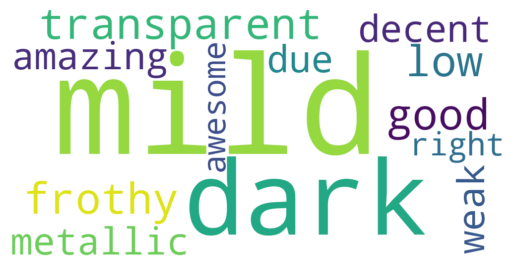

In [192]:
# Combine the strings into one text
text_combined = ' '.join(adjectives)

# Create and generate a word cloud image:
wordcloud = wordcloud.WordCloud(width = 1000, height = 500, background_color = 'white').generate(text_combined)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In this example we can see that the model classified "due" as an adjective will it should be a verb. This is to be expected because all machine learning models will make mistakes sometimes. However as we will be finding the most used adjectives in all the reviews from one country so these mistakes will disappear when taking a large amount of reviews.

#### Climate analysis

We want to know wether the climate of the country influences the ratings of the beers. This could mean that the climate in which a beer is produced impacts its quality. Seen from the point of view of the users, this could mean that people from a specific climate zone prefer specific beers. 

To explore these hypotheses, we will be using a dataset describing the climate of the countries around the world. This dataset includes the Köppen climate classification (see https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification) of the country, referred as climate zone here, and its average yearly temperature. The dataset comes from https://weatherandclimate.com/countries.

Describing a country with one climate zone is an oversimplification of the reality as countries usually have regions with very different climates within themselves. To minimize this, we will later on take a closer look at the United States of America (USA) and Europe as the USA can be broken down by states and Europe has countries that are smaller than in other parts of the world. Moreover, these two regions encompass a large amount of reviews, as shown before.

In [193]:
#load the dataset
countries_climate = pd.read_csv('data/climate_countries.csv')
countries_climate.head()

,Country,Climate zone,Avg °C
0,Afghanistan,DSB,15.70
1,Albania,CSB,15.17
2,Algeria,BWH,20.00
3,American Samoa,AW,28.00
4,Andorra,CFB,7.17


In [194]:
#replace the names of the countries in the climate dataset to match the names in the ratings dataset
countries_climate.loc[countries_climate["Country"].str.contains("United States"), "Country"] = "United States of America"
countries_climate.loc[countries_climate["Country"].str.contains("Czechia"), "Country"] = "Czech Republic"
countries_climate.loc[countries_climate["Country"].str.contains("Slovakia"), "Country"] = "Slovak Republic"
countries_climate.loc[countries_climate["Country"].str.contains("Trinidad and Tobago"), "Country"] = "Trinidad & Tobago"

In [195]:
#keep only the climate from the countries in the dataset
countries_climate = countries_climate[countries_climate['Country'].isin(avg_ratings.brewery_location.unique())]

#print the countries in avg_ratings that are not in countries_climate
print('Country for which there is no climate information: ', avg_ratings[~avg_ratings['brewery_location'].isin(countries_climate['Country'])]['brewery_location'].iloc[0])

Country for which there is no climate information:  Bahamas


In [220]:
# Merge the world map with the climate data
world_climate = world.copy()
world_climate = world_climate.merge(countries_climate, left_on="name", right_on="Country", how="left")
#drop 'Country' column as 'world' already has country names in the column 'name'
world_climate = world_climate.drop(columns=['Country'])

# Merge with the average ratings
world_climate = world_climate.merge(avg_ratings, left_on="name", right_on="brewery_location", how="left")

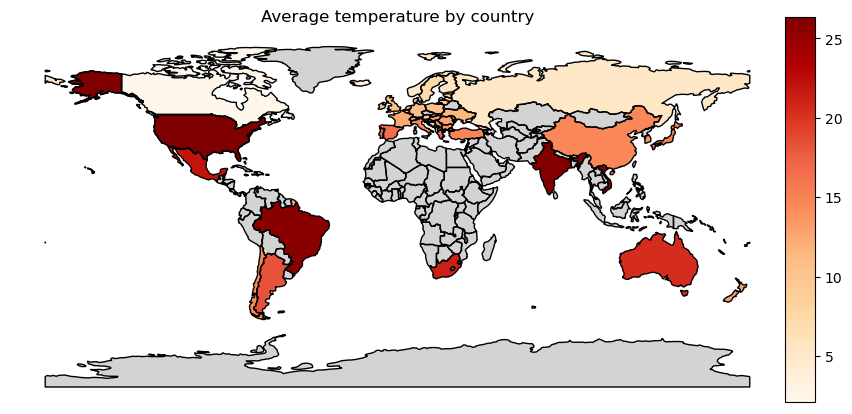

In [197]:
# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
plt.title("Average temperature by country")
world_climate.boundary.plot(ax=ax, linewidth=1, color="black")
ax.set_axis_off()
world_climate.plot(column="Avg °C", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"},cax=fig.add_axes([0.9, 0.23, 0.03, 0.55]))
plt.show()

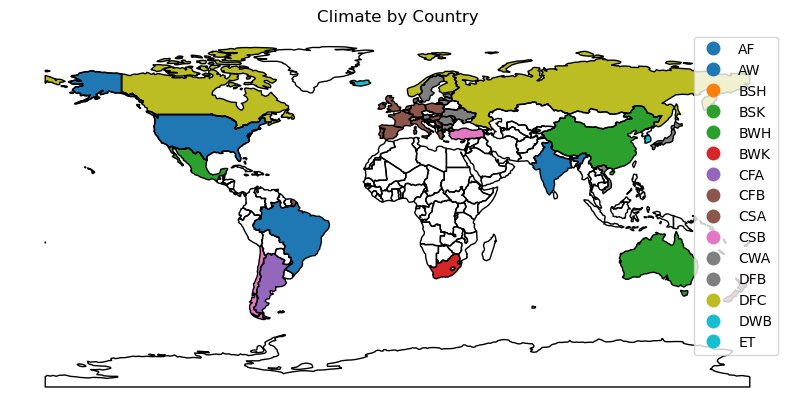

In [223]:
#plot the climate zones

#legend for climate zones
color_mapping = {
    'AF' : (0, 0, 255),
    'AM' : (0, 120, 255),
    'AW' : (70, 170, 255),
    'BSH' : (245, 165, 0),
    'BSK' : (255, 220, 100),
    'BWH' : (255, 0, 0),
    'BWK' : (255, 150, 150),
    'CFA' : (200, 255, 80),
    'CFB' : (100, 255, 80),
    'CSA' : (255, 255, 0),
    'CSB' : (200, 200, 0),
    'CWA' : (150, 255, 150),
    'CWB' : (100, 200, 100),
    'DFB' : (55, 200, 255),
    'DFC' : (0, 125, 125),
    'DSB' : (200, 0, 200),
    'DSC' : (150, 50, 150),
    'DWB' : (90, 120, 220),
    'EF' : (102, 102, 102),
    'ET' : (178, 178, 178),
}

#convert colors into rgba
for key, value in color_mapping.items():
    color_mapping[key] = (value[0]/255, value[1]/255, value[2]/255)

world_climate['color'] = world_climate.loc[:, 'Climate zone'].map(color_mapping)

fig, ax = plt.subplots(1, figsize=(10, 7))
plt.title('Climate by Country')
world_climate.boundary.plot(ax=ax, linewidth=1, color='black')  # Draw country boundaries
ax.set_axis_off()
world_climate.plot(column='Climate zone', ax=ax, legend=True)
plt.show()

Let's show again the map of the ratings as a reminder.

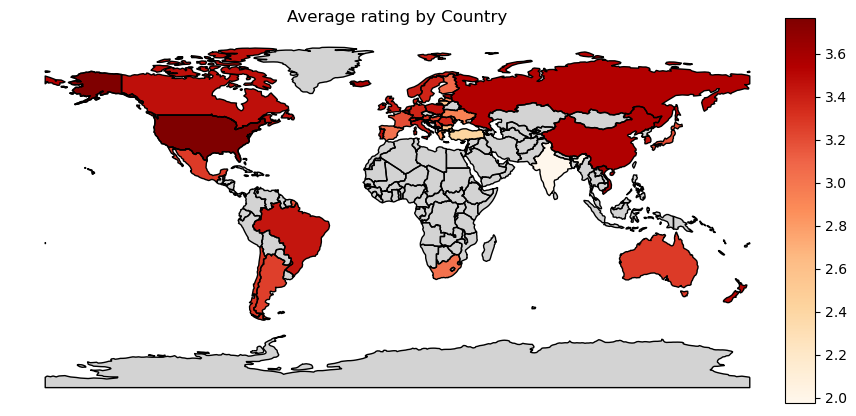

In [226]:
fig, ax = plt.subplots(1, figsize=(10, 7))
plt.title('Average rating by Country')
world_climate.boundary.plot(ax=ax, linewidth=1, color='black')  # Draw country boundaries
ax.set_axis_off()
world_climate.plot(column='avg_rating', ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"},cax=fig.add_axes([0.9, 0.23, 0.03, 0.55]))
plt.show()

Looking at these maps we can see that there are differences but not a clear trend. This shows that it needs further analises to see wether or not there is a correlation between the climate of a country and the ratings of its beers. 

## 3) Second analysis : how users from one country rate beers

### Data cleaning

Remove any users with < 10 reviews, then aggregate by country, then remove any countries with < 10 users

le 10 c'est un peu arbitraire, mais c'est pour éviter d'avoir des pays avec 1 ou 2 users qui ont mis 5 étoiles à une bière et donc qui faussent les moyennes

In [199]:
users_ratings = reviews_df.copy()

#Total number of users that have rated at least one beer
print("Initial number of unique users: ", len(users_ratings["user_id"].unique()))

#Total number of ratings given by users that have rated at least 10 beers
filtered_users_ratings = users_ratings.drop(users_ratings[users_ratings["user_nbr_ratings"]<10].index)
print("Final number of unique users after filtering: ", len(filtered_users_ratings["user_id"].unique()))


Initial number of unique users:  92113
Final number of unique users after filtering:  57409


In [200]:
#Total number of users locations with at least one user
print("Initial number of unique user locations: ", len(users_ratings["user_location"].unique()))

#Compute the total number of users per user location
unique_users_location = filtered_users_ratings.drop_duplicates(subset=["user_name"])
filtered_users_location = unique_users_location.groupby("user_location").agg(
    {"user_name": "count"}
).rename(columns={"user_name": "nbr_users"})

#Total number of users locations that have more than 10 users
filtered_users_location = filtered_users_location[filtered_users_location["nbr_users"] >= 10].sort_values(by="nbr_users", ascending=False)
filtered_users_location = filtered_users_location.reset_index()
final_filtered_users = filtered_users_ratings[filtered_users_ratings["user_location"].isin(filtered_users_location["user_location"])]
print("Final number of unique user locations after filtering: ", len(final_filtered_users["user_location"].unique()))

Initial number of unique user locations:  198
Final number of unique user locations after filtering:  107


In [201]:
##TEST
# check if 'Afghanistan' (user location), that only had 1 user (user_id), had been well removed from the initial dataframe
'Afghanistan' in final_filtered_users['user_location'].values

False

In [202]:
print("Initial number of reviews: ", len(users_ratings))
print("Final number of reviews: ", len(final_filtered_users))
print("Percentage of reviews kept: {:.2f}%".format(len(final_filtered_users) / len(users_ratings) * 100))

Initial number of reviews:  1976606
Final number of reviews:  1816244
Percentage of reviews kept: 91.89%


In [203]:
final_filtered_users.head()

,beer_name,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,...,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings
0,Legbiter,19827,English Pale Ale,1417431600,Hellpop65,hellpop65.48993,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",2326.0
2,Legbiter,19827,English Pale Ale,1393412400,RochefortChris,rochefortchris.697017,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, North Carolina",1866.0
4,Legbiter,19827,English Pale Ale,1390647600,jaydoc,jaydoc.265507,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",9987.0
5,Legbiter,19827,English Pale Ale,1380794400,ejimhof,ejimhof.5743,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Pennsylvania",4078.0
6,Legbiter,19827,English Pale Ale,1366884000,GraduatedCashew,graduatedcashew.730089,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, California",2329.0


In [204]:
'Antartica' in final_filtered_users['user_location'].values

False

### Analysis

Compute some averages for countries, plot them, say there are some diff so we want to investigate
Potentially also wordclouds, here because we explained the dataset in part 2, just say "we gonna do the same"

In [205]:
users_beers = final_filtered_users.copy()

In [206]:
users_name_rating = users_beers.groupby('user_location').agg(
    {"user_name": "count",
     "beer_avg_rating_ba_rb": "mean"}).rename(columns={"user_name": "nbr_users", "beer_avg_rating_ba_rb": "avg_rating"})
users_name_rating = users_name_rating.reset_index()
users_name_rating.head()

,user_location,nbr_users,avg_rating
0,Aotearoa,51,3.403685
1,Argentina,55,3.573264
2,Australia,18708,3.396380
3,Austria,2359,3.429830
4,Belgium,23460,3.470421


C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\1442967616.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


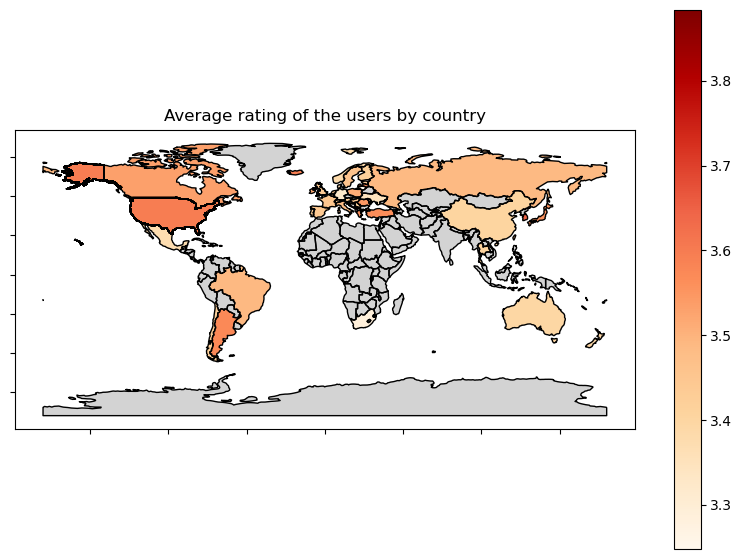

In [207]:
users_average_rating = users_name_rating.copy()

users_average_rating.loc[users_average_rating["user_location"].str.contains("United States"), "user_location"] = "United States of America"
users_average_rating.loc[users_average_rating["user_location"].str.contains("England"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Scotland"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Wales"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Northern Ireland"), "user_location"] = "United Kingdom"

#Plot 
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(users_average_rating, left_on="name", right_on="user_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="avg_rating", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Average rating of the users by country")
plt.show()


In [208]:
print(users_name_rating.sort_values(by="nbr_users", ascending=False).head(20))


                     user_location  nbr_users  avg_rating
60       United States, California     122116    3.792182
6                           Canada     116346    3.532655
93     United States, Pennsylvania      93766    3.730749
68         United States, Illinois      87375    3.783682
87         United States, New York      79280    3.803990
12                         Denmark      73940    3.384505
98            United States, Texas      63263    3.700941
14                         England      63009    3.435270
76    United States, Massachusetts      58914    3.862310
50                          Sweden      53154    3.459103
85       United States, New Jersey      50418    3.747279
90             United States, Ohio      45359    3.726444
102      United States, Washington      43002    3.696359
32                     Netherlands      42542    3.438413
64          United States, Florida      42161    3.713290
78        United States, Minnesota      39693    3.722499
101        Uni

In [209]:
#Plot the same for Europe and US
users_us = users_name_rating[users_name_rating['user_location'].str.contains("United States")]

names_states = users_us['user_location'].unique()
# From each name remove "Unites Sates, "
names_states = [name.replace("United States, ", "") for name in names_states]
users_us['user_location'] = names_states

# Load map from file
us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")

us_map = us_map.merge(users_us, left_on="NAME", right_on="user_location", how="right")

# For display purposes, move Alaska and Hawaii to the East
alaska = us_map[us_map["NAME"] == "Alaska"].geometry
hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

# Shift Alaska to the right
alaska = alaska.translate(xoff=40)
hawaii = hawaii.translate(xoff=40)

us_map_shifted = us_map.copy()
us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii


C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\1516610157.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_us['user_location'] = names_states


In [210]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe_map = world[world["continent"] == "Europe"]

europe_map = europe_map.merge(users_average_rating, left_on="name", right_on="user_location", how="left");

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\1584756039.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


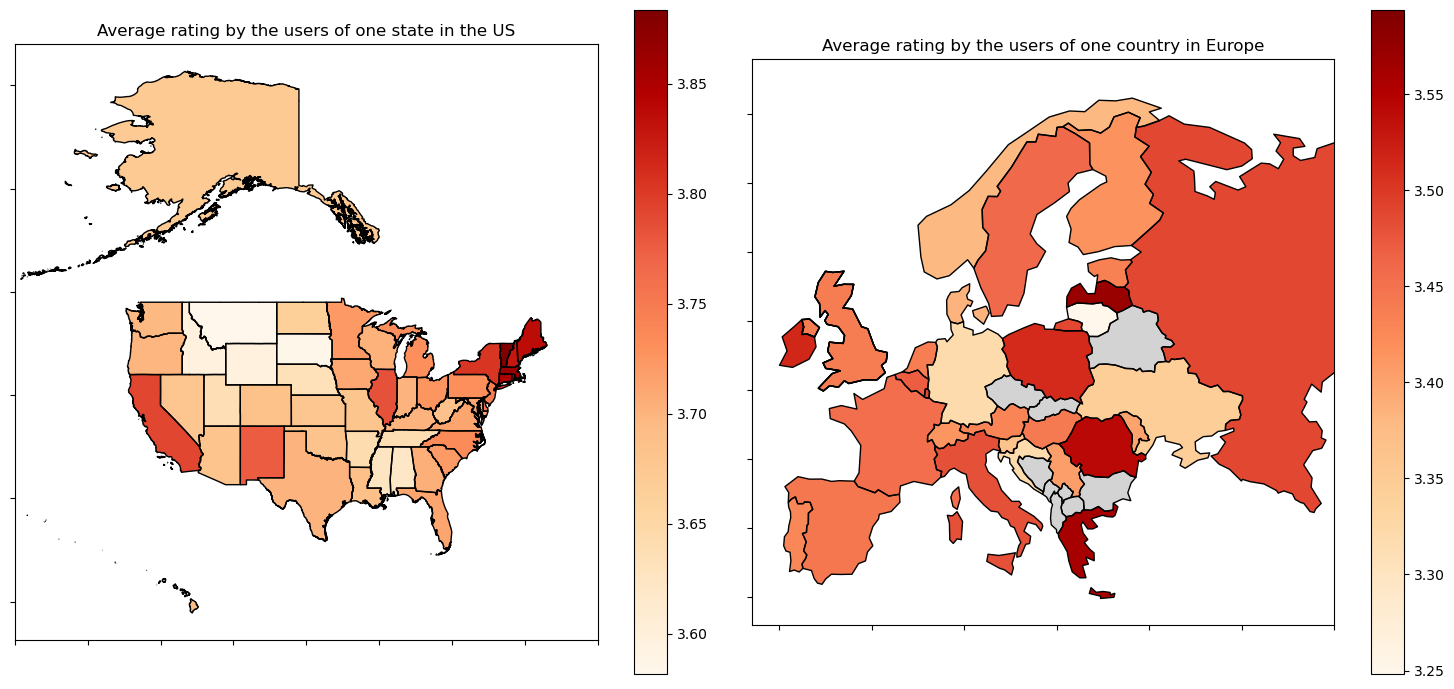

In [211]:
# Plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

us_map_shifted.boundary.plot(ax=ax[0], linewidth=1, color="black")
us_map_shifted.plot(column="avg_rating", ax=ax[0], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim(-140, -60)
ax[0].set_title("Average rating by the users of one state in the US")


europe_map.boundary.plot(ax=ax[1], linewidth=1, color="black")
europe_map.plot(column="avg_rating", ax=ax[1], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlim(-13, 50)
ax[1].set_ylim(33, 74)
ax[1].set_title("Average rating by the users of one country in Europe")

plt.tight_layout()
plt.show()

In [212]:
users_average_rating.head()

,user_location,nbr_users,avg_rating
0,Aotearoa,51,3.403685
1,Argentina,55,3.573264
2,Australia,18708,3.396380
3,Austria,2359,3.429830
4,Belgium,23460,3.470421


In [213]:

#for each country compute the total number of users
users_per_country = users_average_rating.groupby("user_location").agg({"nbr_users": "sum"}).sort_values(by="nbr_users", ascending=False).head(20)
users_per_country = users_per_country.reset_index()

#compute the total number of users
total_users = users_per_country["nbr_users"].sum()

#add a column percentage of users
users_per_country["percentage_users"] = users_per_country["nbr_users"] / total_users * 100

users_per_country.head()


,user_location,nbr_users,percentage_users
0,United States of America,1206944,68.019531
1,Canada,116346,6.556891
2,United Kingdom,80429,4.532723
3,Denmark,73940,4.167024
4,Sweden,53154,2.995591


C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\2816673305.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


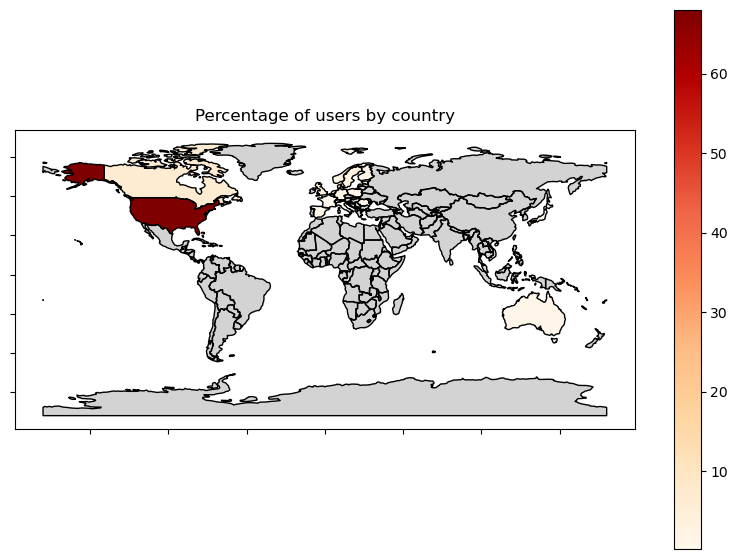

In [214]:
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(users_per_country, left_on="name", right_on="user_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="percentage_users", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Percentage of users by country")
plt.show()

## Last analysis : how beers from one country are rated by users from another country

In [215]:
target_country = "Germany"

germany_df = final_filtered_users.copy()

germany_df = germany_df[germany_df.brewery_location == target_country]

print(len(germany_df))

80424


C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_17020\1183187970.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


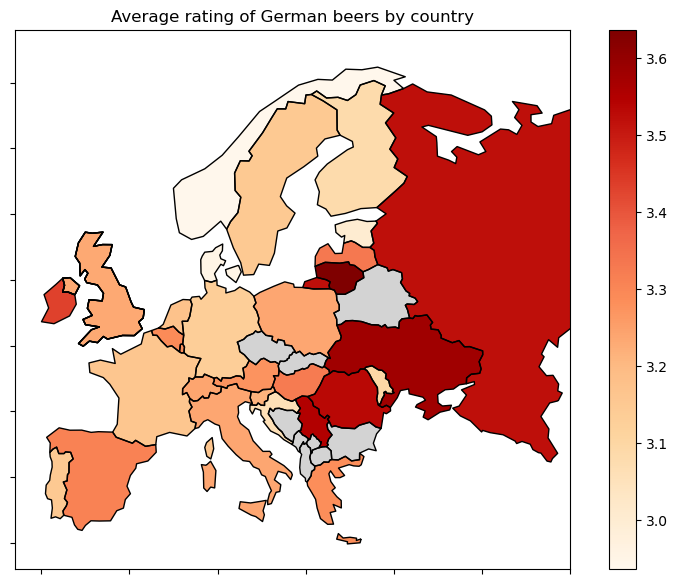

In [216]:
opinion_df = germany_df.copy()

opinion_df["rating"] = opinion_df["rating"].astype(float)
opinion_df = opinion_df.groupby('user_location')["rating"].mean()
opinion_df = opinion_df.to_frame().reset_index()
opinion_df.columns = ["user_location", "avg_rating"]

opinion_df.loc[opinion_df["user_location"].str.contains("United States"), "user_location"] = "United States of America"
opinion_df.loc[opinion_df["user_location"].str.contains("England"), "user_location"] = "United Kingdom"
opinion_df.loc[opinion_df["user_location"].str.contains("Scotland"), "user_location"] = "United Kingdom"
opinion_df.loc[opinion_df["user_location"].str.contains("Wales"), "user_location"] = "United Kingdom"
opinion_df.loc[opinion_df["user_location"].str.contains("Northern Ireland"), "user_location"] = "United Kingdom"

#Plot 
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe_map = world[world["continent"] == "Europe"]
europe_map = europe_map.merge(opinion_df, left_on="name", right_on="user_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
europe_map.boundary.plot(ax=ax, linewidth=1, color="black")
europe_map.plot(column="avg_rating", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(-13, 50)
ax.set_ylim(33, 74)
plt.title("Average rating of German beers by country")
plt.show()
